In [15]:
# from fiam
import datetime
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA

print(datetime.datetime.now())

# turn off pandas Setting with Copy Warning
pd.set_option("mode.chained_assignment", None)

# set working directory
work_dir = "/content/"

# read sample data
file_path = os.path.join(
    work_dir, "hackathon_sample_v2.csv"
)  # replace with the correct file name
raw = pd.read_csv(
    file_path, low_memory=False, sep=';',parse_dates=["date"]
)  # the date is the first day of the return month (t+1)

# read list of predictors for stocks
file_path = os.path.join(
    work_dir, "factor_char_list.csv"
)  # replace with the correct file name
stock_vars = list(pd.read_csv(file_path)["variable"].values)

# define the left hand side variable
ret_var = "stock_exret" #possibly change?
new_set = raw[
    raw[ret_var].notna()
].copy()  # create a copy of the data and make sure the left hand side is not missing


2024-09-27 22:25:39.484892


In [16]:
import pandas as pd
import numpy as np

# Assuming new_set and stock_vars are already defined
monthly = new_set.groupby("date")
data = pd.DataFrame()

for date, monthly_raw in monthly:
    group = monthly_raw.copy()
    # Convert all columns to numeric, forcing errors to NaN
    group[stock_vars] = group[stock_vars].apply(pd.to_numeric, errors='coerce')

    # Rank transform each variable to [-1, 1]
    for var in stock_vars:
        var_median = group[var].median(skipna=True)
        group[var] = group[var].fillna(var_median)  # Fill missing values with the cross-sectional median of each month

        group[var] = group[var].rank(method="dense") - 1
        group_max = group[var].max()
        if group_max > 0:
            group[var] = (group[var] / group_max) * 2 - 1
        else:
            group[var] = 0  # In case of all missing values
            print("Warning:", date, var, "set to zero.")

    # Add the adjusted values
    data = pd.concat([data, group], ignore_index=True)

# Initialize the starting date, counter, and output data
starting = pd.to_datetime("20000101", format="%Y%m%d")
counter = 0
pred_out = pd.DataFrame()

IMPORTANT : Ici pour pourvoir par la suite calculer la matrice de seriation j'ai du enlever les stocks qui comportait des Nan. On a donc mtn plus que 281 stocks.

In [34]:
# Définir la plage de dates
start = '2000-01-31'
end = '2009-12-31'

# Filtrer les données par plage de dates
filtered_data = data.loc[(data['date'] >= start) & (data['date'] <= end)]

# Utiliser pivot pour réorganiser le DataFrame et supprimer les lignes avec des valeurs manquantes
new_dataframe = filtered_data.pivot(index='date', columns='stock_ticker', values='ret_1_0')

# Supprimer les colonnes avec des valeurs manquantes
new_dataframe = new_dataframe.dropna(axis=1)

new_dataframe

stock_ticker,AA,AAPL,ABT,ACS,ADBE,ADI,ADSK,AEE,AFL,AGN,...,WMT,WPI,WY,X,XLNX,XOM,XRAY,XRX,YHOO,ZION
date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,0.658497,0.037582,-0.560458,0.601307,-0.397059,0.921569,0.433007,-0.483660,-0.357843,-0.176471,...,0.560458,-0.490196,0.490196,0.715686,-0.145425,-0.147059,-0.330065,-0.936275,0.982026,-0.750000
2000-02-29,-0.635304,0.303913,-0.317236,-0.515404,-0.741882,0.280600,-0.285595,0.218984,-0.199001,0.741882,...,-0.838468,0.715237,-0.801832,-0.900083,0.285595,0.443797,0.498751,-0.200666,-0.911740,0.272273
2000-03-31,-0.015385,0.324615,0.078462,-0.889231,0.890769,0.843077,0.733846,-0.330769,-0.712308,-0.533846,...,-0.493846,0.000000,-0.481538,-0.510769,0.861538,-0.400000,0.150769,0.167692,-0.001538,-0.463077
2000-04-28,-0.351438,0.367412,-0.175719,0.448882,-0.047923,-0.361022,-0.386581,-0.241214,0.597444,-0.458466,...,0.234824,-0.464856,0.055911,0.174121,-0.292332,-0.308307,0.049521,0.445687,-0.146965,-0.821086
2000-05-31,-0.406143,-0.452218,0.593857,-0.600683,0.535836,-0.215017,-0.679181,0.831058,0.470990,0.815700,...,-0.049488,0.711604,-0.329352,0.073379,-0.563140,0.051195,0.208191,0.187713,-0.827645,0.054608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-08-31,0.421112,0.477866,-0.861521,-0.175936,0.471056,0.182747,0.489217,-0.598184,0.782066,0.318956,...,-0.532350,-0.525539,0.523269,0.241771,-0.253121,-0.673099,0.062429,0.879682,-0.947787,0.636776
2009-09-30,-0.081329,-0.063001,-0.333333,-0.844215,-0.704467,0.085911,0.459336,0.347079,0.486827,0.189003,...,-0.090493,-0.209622,0.390607,0.631157,-0.019473,-0.539519,-0.264605,0.280641,-0.154639,0.956472
2009-10-30,0.368421,0.482838,0.418764,0.890160,0.006865,-0.741419,-0.377574,-0.876430,0.016018,-0.389016,...,-0.821510,-0.135011,-0.711670,-0.416476,0.027460,-0.620137,-0.283753,-0.965675,0.906178,-0.366133


In [ ]:
%pip install Riskfolio-Lib

IMPORTANT : Ici pour pouvoir voir nos visuels, j'ai choisi juste aléatoirement 50 stocks parmis nos stocks. Si on utilisera ça, on pourra choisir notre n en fonction des 50 à 100 stocks avec le meilleur expected return !

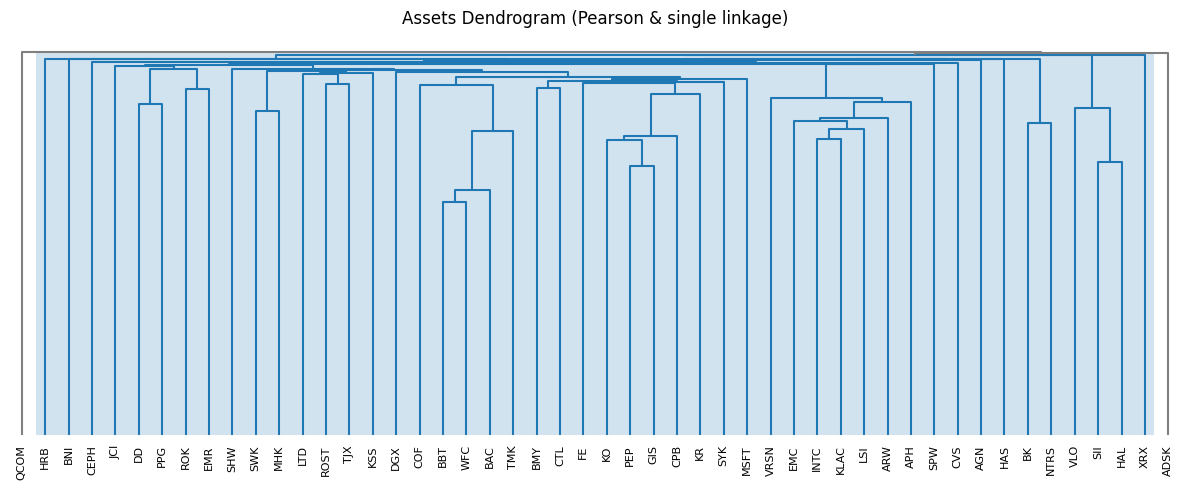

In [43]:
import riskfolio as rp

# Plotting Assets Clusters

import riskfolio as rp

# Supposons que ton DataFrame s'appelle 'new_dataframe'
# et qu'il contient les retours des actifs
returns = new_dataframe

# Sélectionner aléatoirement 50 actions parmi les 200
selected_stocks = returns.sample(n=50, axis=1, random_state=42)

# Créer le dendrogramme
ax = rp.plot_dendrogram(returns=selected_stocks,
                        codependence='pearson',
                        linkage='single',
                        k=None,
                        max_k=10,
                        leaf_order=True,
                        ax=None)


In [44]:
# Building the portfolio object
port = rp.HCPortfolio(returns=selected_stocks)

# Estimate optimal portfolio:

model='HRP' # Could be HRP or HERC
codependence = 'pearson' # Correlation matrix used to group assets in clusters
rm = 'MV' # Risk measure used, this time will be variance
rf = 0 # Risk free rate
linkage = 'single' # Linkage method used to build clusters
max_k = 10 # Max number of clusters used in two difference gap statistic, only for HERC model
leaf_order = True # Consider optimal order of leafs in dendrogram

w = port.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      linkage=linkage,
                      max_k=max_k,
                      leaf_order=leaf_order)

display(w.T)

,BBT,LTD,TMK,VLO,FE,AGN,KSS,PEP,KO,LSI,...,DGX,INTC,SWK,HAL,SII,TJX,MHK,ADSK,SYK,CTL
weights,0.011141,0.012051,0.014656,0.023399,0.012573,0.029642,0.015627,0.02099,0.031256,0.012622,...,0.016001,0.024941,0.015245,0.016285,0.017366,0.01132,0.009077,0.021052,0.026819,0.012561


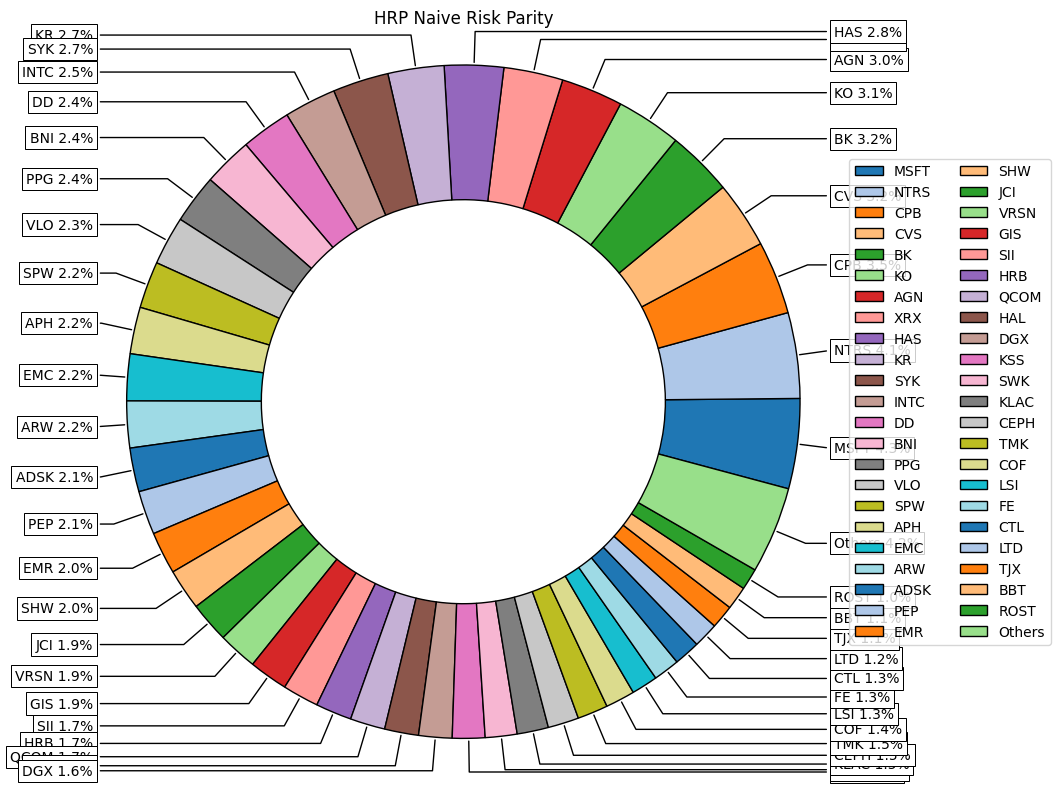

In [45]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w,
                 title='HRP Naive Risk Parity',
                 others=0.05,
                 nrow=25,
                 cmap="tab20",
                 height=8,
                 width=10,
                 ax=None)

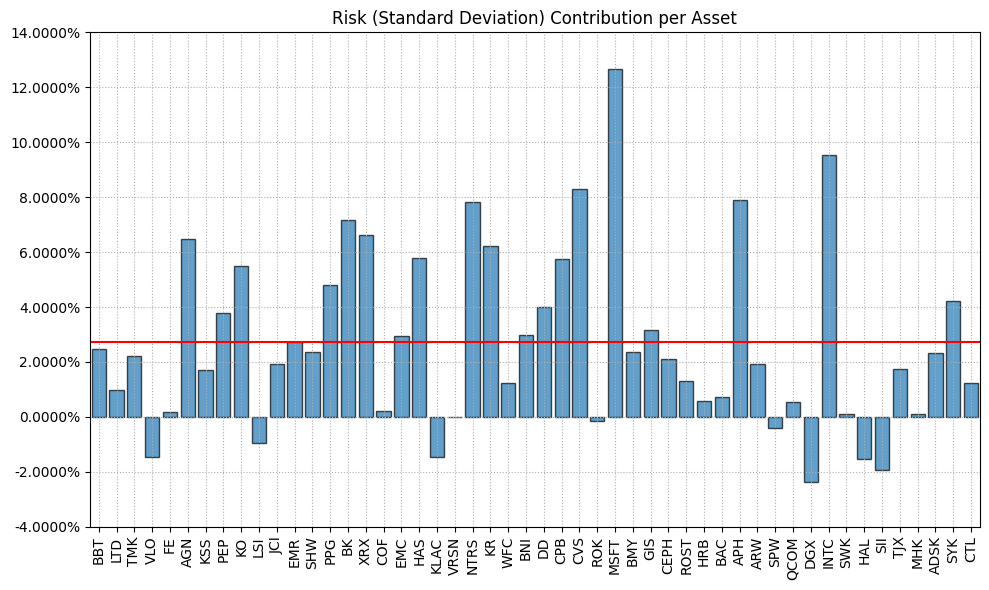

In [46]:
# Plotting the risk contribution per asset

mu = selected_stocks.mean()
cov = selected_stocks.cov() # Covariance matrix
returns = selected_stocks # Returns of the assets

ax = rp.plot_risk_con(w=w,
                      cov=cov,
                      returns=returns,
                      rm=rm,
                      rf=0,
                      alpha=0.05,
                      color="tab:blue",
                      height=6,
                      width=10,
                      t_factor=252,
                      ax=None)